# [Ex5] 네이버 영화리뷰 감성분석

## 데이터 준비와 확인

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt            # 앞서 konlpy 다운 받기!!! + Mecab도
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성
+ 데이터의 중복 제거
+ NaN 결측치 제거
+ 한국어 토크나이저로 토큰화
+ 불용어(Stopwords) 제거
+ 사전word_to_index 구성
+ 텍스트 스트링을 사전 인덱스 스트링으로 변환
+ X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 되는 단어 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist): #사전word_to_index 구성
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)


In [4]:
# index_to_word 생성
# 텍스트 데이터 -> 숫자로 바꾸기 // 딕셔너리가 {텍스트:인덱스} 구조여야 한다.

index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공
+ 데이터셋 내 문장 길이 분포
+ 적절한 최대 문장 길이 지정
+ keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [6]:
#데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

#적절한 최대 문장 길이 지정
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
#keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델구성 및 validation set 구성(3가지 모델)
+ 1) LSTM
+ 2) 1-D Convolution Neural Network(1-D CNN)
+ 3) GlobalMaxPooling1D() 
+ 4) 한글 Word2Vec

### 1) LSTM 모델 

In [8]:
# validation set 30000건 분리     적절한 validataion 데이터는 몇개가 좋을까?
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 41)
(30000,)
(116182, 41)
(116182,)


In [35]:
vocab_size = len(index_to_word)   # 어휘 사전의 크기입니다.
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
lstm_model = keras.Sequential(name="LSTM")
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
lstm_model.add(keras.layers.Dense(8, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 모델 학습 시작
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = lstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 5s 20ms/step - loss: 0.4676 - accuracy: 0.8001 - val_loss: 0.3562 - val_accuracy: 0.8476
Epoch 2/20
227/227 [==============================] - 4s 19ms/step - loss: 0.3310 - accuracy: 0.8608 - val_loss: 0.3455 - val_accuracy: 0.8496
Epoch 3/20
227/227 [==============================] - 4s 19ms/step - loss: 0.3042 - accuracy: 0.8725 - val_loss: 0.3441 - val_accuracy: 0.8512
Epoch 4/20
227/227 [==============================] - 4s 17ms/step - loss: 0.2866 - accuracy: 0.8803 - val_loss: 0.3477 - val_accuracy: 0.8520
Epoch 5/20
227/227 [==============================] - 4s 18ms/step - loss: 0.2716 - accuracy: 0.8869 - val_loss: 0.3579 - val_accuracy: 0.8512
Epoch 6/20
227/227 [==============================] - 4s 18ms/step - loss: 0.2570 - accuracy: 0.8937 - val_loss: 0.3669 - val_accuracy: 0.8485
Epoch 7/20
227/227 [==============================] - 4s 17ms/step - loss: 0.2440 - accuracy: 0.8996 - val_loss: 0.3766 - val_accuracy: 0.8487

In [37]:
# 학습 끝난 모델을 테스트셋으로 평가하기
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)

1537/1537 - 6s - loss: 0.5582 - accuracy: 0.8300
[0.5581883788108826, 0.8299530148506165]


### 2) 1-D Convolution Neural Network(1-D CNN)

In [38]:
vocab_size = len(index_to_word)   # 어휘 사전의 크기
word_vector_dim = 100       # 단어 하나를 표현하는 임베딩 벡터의 차원수

CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9       

In [39]:
# 모델 학습 시작
CNN_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = CNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 18ms/step - loss: 0.4701 - accuracy: 0.7694 - val_loss: 0.3440 - val_accuracy: 0.8494
Epoch 2/20
227/227 [==============================] - 4s 19ms/step - loss: 0.3118 - accuracy: 0.8682 - val_loss: 0.3282 - val_accuracy: 0.8582
Epoch 3/20
227/227 [==============================] - 4s 19ms/step - loss: 0.2606 - accuracy: 0.8940 - val_loss: 0.3334 - val_accuracy: 0.8569
Epoch 4/20
227/227 [==============================] - 4s 18ms/step - loss: 0.2082 - accuracy: 0.9203 - val_loss: 0.3508 - val_accuracy: 0.8540
Epoch 5/20
227/227 [==============================] - 4s 18ms/step - loss: 0.1492 - accuracy: 0.9470 - val_loss: 0.3902 - val_accuracy: 0.8500
Epoch 6/20
227/227 [==============================] - 4s 17ms/step - loss: 0.1016 - accuracy: 0.9668 - val_loss: 0.4519 - val_accuracy: 0.8470
Epoch 7/20
227/227 [==============================] - 4s 19ms/step - loss: 0.0703 - accuracy: 0.9777 - val_loss: 0.5372 - val_accuracy: 0.8424

In [40]:
# 학습 끝난 모델을 테스트셋으로 평가하기
CNN_results = CNN_model.evaluate(X_test,  y_test, verbose=2)

print(CNN_results)

1537/1537 - 4s - loss: 1.1065 - accuracy: 0.8240
[1.1065272092819214, 0.8239518404006958]


### 3)GlobalMaxPooling1D()

In [45]:
vocab_size = len(index_to_word)   # 어휘 사전의 크기
word_vector_dim = 100       # 단어 하나를 표현하는 임베딩 벡터의 차원수

MaxPooling1D_model = keras.Sequential(name="GlabalMaxPooling1D")
MaxPooling1D_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
MaxPooling1D_model.add(keras.layers.GlobalMaxPooling1D())
MaxPooling1D_model.add(keras.layers.Dense(8, activation='relu'))
MaxPooling1D_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

MaxPooling1D_model.summary()

Model: "GlabalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [46]:
# 모델 학습 시작
MaxPooling1D_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을까?

history = MaxPooling1D_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 15ms/step - loss: 0.4999 - accuracy: 0.7925 - val_loss: 0.3603 - val_accuracy: 0.8420
Epoch 2/20
227/227 [==============================] - 4s 16ms/step - loss: 0.3271 - accuracy: 0.8612 - val_loss: 0.3379 - val_accuracy: 0.8524
Epoch 3/20
227/227 [==============================] - 4s 15ms/step - loss: 0.2813 - accuracy: 0.8846 - val_loss: 0.3376 - val_accuracy: 0.8539
Epoch 4/20
227/227 [==============================] - 4s 16ms/step - loss: 0.2465 - accuracy: 0.9027 - val_loss: 0.3466 - val_accuracy: 0.8544
Epoch 5/20
227/227 [==============================] - 4s 16ms/step - loss: 0.2142 - accuracy: 0.9181 - val_loss: 0.3637 - val_accuracy: 0.8518
Epoch 6/20
227/227 [==============================] - 4s 16ms/step - loss: 0.1832 - accuracy: 0.9323 - val_loss: 0.3838 - val_accuracy: 0.8513
Epoch 7/20
227/227 [==============================] - 4s 16ms/step - loss: 0.1524 - accuracy: 0.9469 - val_loss: 0.4093 - val_accuracy: 0.8499

In [47]:
# 학습 끝난 모델을 테스트셋으로 평가하기
MaxPooling1D_results = MaxPooling1D_model.evaluate(X_test,  y_test, verbose=2)

print(MaxPooling1D_results)

1537/1537 - 2s - loss: 0.8568 - accuracy: 0.8294
[0.8567613363265991, 0.8293834328651428]


- 모두 같은 조건을 가지고 모델 학습을 하여 테스트셋으로 평가하였다.
```
vocab_size = len(index_to_word)   # 어휘 사전의 크기
word_vector_dim = 100       # 단어 하나를 표현하는 임베딩 벡터의 차원수
```

In [56]:
print("LSTM 모델의 성능")
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
print("CNN 모델의 성능")
CNN_results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print("MaxPooling1D 모델의 성능")
MaxPooling1D_results = MaxPooling1D_model.evaluate(X_test,  y_test, verbose=2)


LSTM 모델의 성능
1537/1537 - 7s - loss: 0.5582 - accuracy: 0.8300
CNN 모델의 성능
1537/1537 - 4s - loss: 1.1065 - accuracy: 0.8240
MaxPooling1D 모델의 성능
1537/1537 - 2s - loss: 0.8568 - accuracy: 0.8294


각 모델의 accuracy를 비교하였을 때, **LSTM**의 성능이 가장 높았으며, 판단하였으며 이를 이후 학습 모델로 선정하여 성능 개선을 할 예정이다.

In [17]:
vocab_size = len(index_to_word)   # 어휘 사전의 크기입니다.
word_vector_dim = 1000  # 단어 하나를 표현하는 임베딩 벡터의 차원수(변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
lstm2_model = keras.Sequential(name="LSTM2")
lstm2_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm2_model.add(keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 변경가능
lstm2_model.add(keras.layers.Dense(8, activation='relu'))
lstm2_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm2_model.summary()

Model: "LSTM2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 1000)        10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                132224    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 10,132,497
Trainable params: 10,132,497
Non-trainable params: 0
_________________________________________________________________


In [18]:

# 오버피팅 없애기
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
     #validataion set의 loss를 monitoring 한다
     #performance measuer(어떤 성능을 모니터링 할것인가?) 를 최소화 시켜야하는 training이다.
     #verbose=1 : 언제 keras에서 training을 멈추었는지 화면에 출력
     #patience : 성능이 더이상 증가하지 않은 epoch를 몇 번이나 허용할 것인가?
    
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

 #EarlyStopping 객체에 의해 training이 중지되었을 때, validation performance가 가장 높았던 모델 선정



In [20]:
# 모델 학습 시작
lstm2_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = lstm2_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es,mc])


Epoch 1/20
454/454 [==============================] - 57s 126ms/step - loss: 0.3902 - accuracy: 0.8261 - val_loss: 0.3356 - val_accuracy: 0.8548
Epoch 2/20
454/454 [==============================] - 57s 125ms/step - loss: 0.2949 - accuracy: 0.8749 - val_loss: 0.3301 - val_accuracy: 0.8588
Epoch 3/20
454/454 [==============================] - 55s 122ms/step - loss: 0.2487 - accuracy: 0.8964 - val_loss: 0.3370 - val_accuracy: 0.8606
Epoch 4/20
454/454 [==============================] - 60s 131ms/step - loss: 0.2061 - accuracy: 0.9163 - val_loss: 0.3643 - val_accuracy: 0.8578
Epoch 5/20
454/454 [==============================] - 59s 130ms/step - loss: 0.1690 - accuracy: 0.9344 - val_loss: 0.3855 - val_accuracy: 0.8563
Epoch 00005: early stopping


In [21]:
# 학습 끝난 모델을 테스트셋으로 평가하기
lstm2_results = lstm2_model.evaluate(X_test,  y_test, verbose=2)

print(lstm2_results)

1537/1537 - 6s - loss: 0.3895 - accuracy: 0.8531
[0.38945603370666504, 0.8530829548835754]


## Loss, Accuracy 그래프 시각화  
- model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있다.
- 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 방안을 알 수있다.

In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


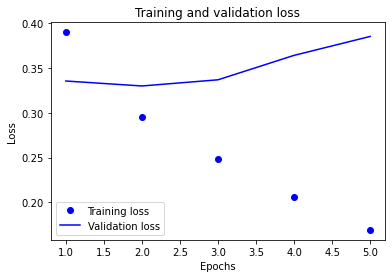

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

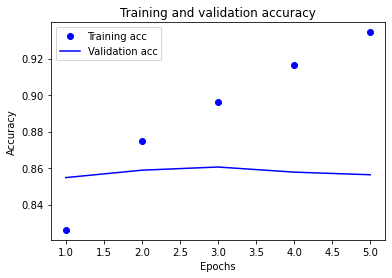

In [24]:
# Training and validation accuracy 그리기
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

임베딩 벡터 차원수 -> 100 - accuracy : 0.8300  
       -> 500 - accuracy: 0.8412 (오버피팅 발생)  
       -> 500 - accuracy : 0.8496 (dropout/earlystopping 진행 했으나 정확도를 더 높여야 한다.) 
       -> 1000 - accuracy : 0.8531 (bach size 줄이고, 워드 벡터 차원수를 늘인 만큼 LSTM state 벡터의 차원수도 높였다.)
       

## 학습된 Embedding 레이어 분석

In [26]:
embedding_layer = lstm2_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 1000)
